<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

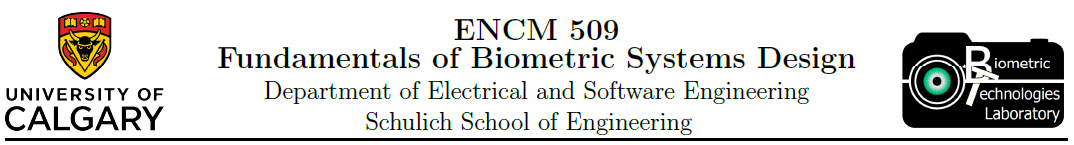

<center>
    <h1>Laboratory Experiment #5</h1>
    <h3>Fingerprint Biometrics - Part II: Matching</h3>
</center>

In [1]:
import cv2 as cv
import numpy as np

from skimage.io import imread, imsave
from skimage.util import img_as_ubyte, invert
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median, gaussian

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.align2 import align2
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

from utils.MatchGaborFeat import MatchGaborFeat

In [2]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

### Images from the `same` person

In [3]:
# both images HAVE to have the same size!!
im1 = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/2.bmp', as_gray=True))
im2 = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/3.bmp', as_gray=True))

In [4]:
Fp1 = fingerprint_processing(im1, block_size=12, threshold=0.1)
Fp2 = fingerprint_processing(im2, block_size=12, threshold=0.1)

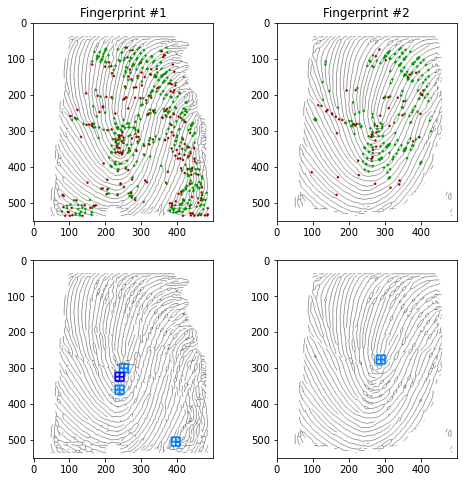

In [5]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(Fp1['minutiae_img'])
plt.title('Fingerprint #1')
plt.subplot(2,2,2)
plt.imshow(Fp2['minutiae_img'])
plt.title('Fingerprint #2')
plt.subplot(2,2,3)
plt.imshow(Fp1['singularities_img'])
plt.subplot(2,2,4)
plt.imshow(Fp2['singularities_img']);

#### Matching: Minutiae based

In [6]:
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

# Align the two fingerprints for better matching
imSkeletonAlign, minutiaArrayAlign = align2(Fp1, Fp2)
Fp2['imSkeletonAlign'] = imSkeletonAlign
Fp2['minutiaArrayAlign'] = minutiaArrayAlign

match_threshold = 6
score = match(Fp1, Fp2, threshold2=match_threshold)
print('score for minutiae: %.4f\n' % (score))

number of matched minutiae: 128
distance total computed : 580
number of minutiae in input image: 2518
number of minutiae in database image: 839
score for minutiae: 0.0763



### Images from two `different` people

In [7]:
im3 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
im4 = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/4.bmp', as_gray=True))

In [8]:
Fp3 = fingerprint_processing(im3, block_size=12, threshold=0.1)
Fp4 = fingerprint_processing(im4, block_size=12, threshold=0.1)

#### Matching: Minutiae based

In [9]:
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

# Align the two fingerprints for better matching
imSkeletonAlign, minutiaArrayAlign = align2(Fp3, Fp4)
Fp4['imSkeletonAlign'] = imSkeletonAlign
Fp4['minutiaArrayAlign'] = minutiaArrayAlign

match_threshold = 6
score = match(Fp3, Fp4, threshold2=match_threshold)
print('score for minutiae: %.4f\n' % (score))

number of matched minutiae: 164
distance total computed : 754
number of minutiae in input image: 3468
number of minutiae in database image: 756
score for minutiae: 0.0777

